<a href="https://colab.research.google.com/github/divya-r-kamat/PyTorch/blob/master/MNIST_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will train an MLP to classify, images from MNIST (hand-written) digit database.

We will follow below steps
- Load data
- Visualise data
- Define neural network
- Train the model
- Evaluate the performance of the model
- Visualize the performance metrics

Import necessary libraries

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from  torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

We download the data and create a PyTorch dataset using the MNIST class from torchvision.datasets.

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())
test_dataset = MNIST(root='data/', train=False, transform=ToTensor())

Next, let's use the random_split helper function to set aside 10000 images for our validation set.

In [3]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [4]:
batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

Host to GPU copies are much faster when they originate from pinned (page-locked) memory. For data loading, passing pin_memory=True to a DataLoader will automatically put the fetched data Tensors in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.

Let's visualize a batch of data in a grid using the make_grid function from torchvision. We'll also use the .permute method on the tensor to move the channels to the last dimension, as expected by matplotlib.

In [5]:
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

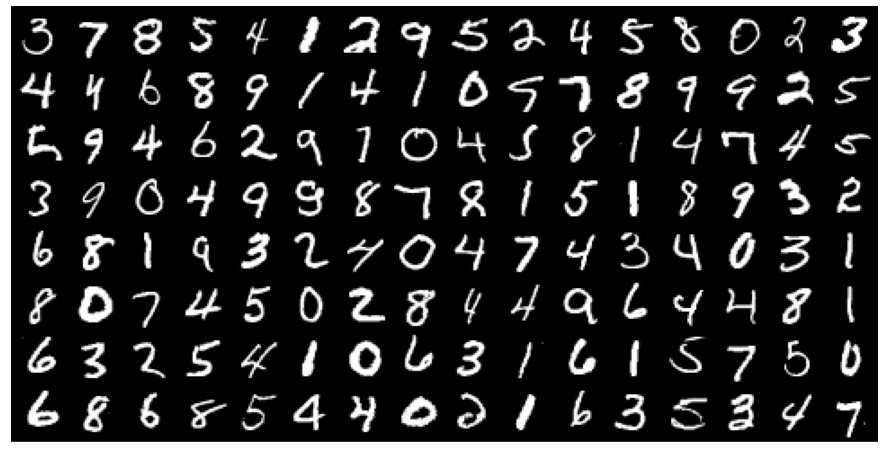

In [6]:
show_batch(train_loader)


### View an Image in more details

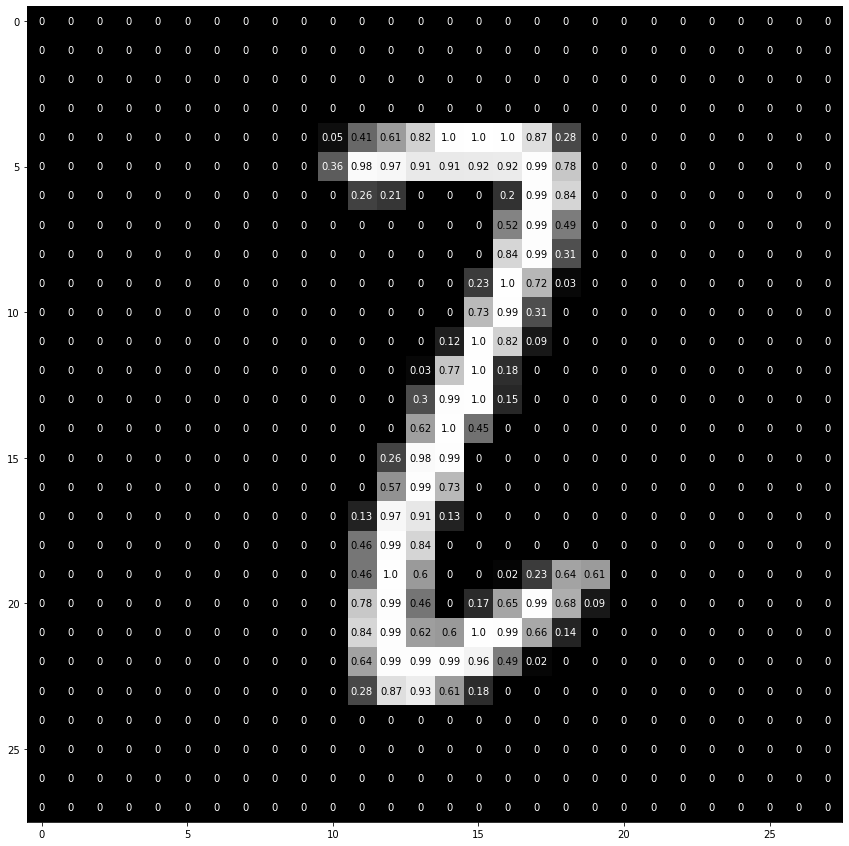

In [7]:
#obtain one batch of training images
dataiter = iter(train_loader)
images,labels = dataiter.next()
#images = images.numpy()
## add one more dimension for batch_size
img = images[1].squeeze()
#img=img.numpy()


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')

width,height = img.shape
thresh = img.max()/2.5

for x in range(width):
  for y in range(height):
    val = (torch.round((img[x][y]*100))).item()/100 if img[x][y] !=0 else 0
    ax.annotate(str(val),xy = (y,x),
                horizontalalignment='center',
                verticalalignment='center',
                color='white'if  img[x][y] < thresh else 'black')




## Evaluation Metric and Loss Function¶
Let's first define out evaluation metric, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the accuracy of the prediction

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


Here we are using torch.max() function, this function's default behaviour as you can guess by the name is to return maximum among the elements in the Tensor. However, this function also helps get the maximum along a particular dimension, as a Tensor, instead of a single element. To specify the dimension (axis – in numpy), there is another optional keyword argument, called dim. This represents the direction that we take for the maximum.

*max_elements, max_indices = torch.max(input_tensor, dim)*

- dim=0, (maximum along columns).
- dim=1 (maximum along rows).

This returns a tuple, max_elements and max_indices.

* max_elements -> All the maximum elements of the Tensor.
* max_indices -> Indices corresponding to the maximum elements.

In the above accuracy function, the == performs an element-wise comparison of two tensors with the same shape, and returns a tensor of the same shape, containing 0s for unequal elements, and 1s for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

## Loss Function
While the accuracy is a great way for us (humans) to evaluate the model, it can't be used as a loss function for optimizing our model using gradient descent, for the following reasons:

It's not a differentiable function. torch.max and == are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

Due to these reasons, accuracy is a great evaluation metric for classification, but not a good loss function. A commonly used loss function for classification problems is the cross entropy,

## How Cross Entropy works
For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are [0.1, 0.3, 0.2, ...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest.

Then, take the logarithm of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function.

PyTorch provides an efficient and tensor-friendly implementation of cross entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the outputs of the model without converting them into probabilities.

In [9]:
class MnistModelBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_loss'], result['val_loss'], result['val_acc']))

## Model
We'll create a neural network with two hidden layer. Here's what this means:

- Instead of using a single nn.Linear object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities), we'll use three nn.Linear objects. Each of these is called a layer in the network.

- The first layer (also known as the hidden layer) will transform the input matrix of shape batch_size x 784 into an intermediate output matrix of shape batch_size x hidden_size, where hidden_size is a preconfigured parameter (e.g. 32 or 64).

- The intermediate outputs are then passed into a non-linear activation function, which operates on individual elements of the output matrix.

- The result of the activation function, which is also of size batch_size x hidden_size, is passed into the second layer , which transforms it into a matrix of size batch_size x hidden_size2

- This is then passed to another activation function which is of size batch_size x hidden_size2, which is then passed onto the third layer (also knowns as the output layer), which transforms it into a matrix of size batch_size x 10

Introducing a hidden layer and an activation function allows the model to learn more complex, multi-layered and non-linear relationships between the inputs and the targets.

The activation function we'll use here is called a Rectified Linear Unit or ReLU, and it has a really simple formula: relu(x) = max(0,x) i.e. if an element is negative, we replace it by 0, otherwise we leave it unchanged.

To define the model, we extend the nn.Module class

In [10]:
class MnistModel(MnistModelBase):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self, in_size, hidden_size1, hidden_size2, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size1)
        # hidden layer 2
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        # output layer
        self.linear3 = nn.Linear(hidden_size2, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out

### Using a GPU
As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers.

define helper functions

In [11]:
#function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# a function that can move data and model to a chosen device.    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


#Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move data to the selected device, 
#as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. 
#All we need is an __iter__ method to retrieve batches of data, and an __len__ method to get the number of batches.

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now wrap our data loaders using DeviceDataLoader.

In [12]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)


### Model Training




Steps for training is defined below:
- forward pass : compute predicted outputs by passing inputs to the model
- calculate the loss
- Backward pass 
- perform single optimization step (parameter update)
- Clear the gradients for all optimized variables
- update average training loss

#### Test the trained Network

Finally, we test our best model on previously unseen test data and evaluate its performance. Testing on unseen data is good way to check our model perforamance to see if our model generalizes well. It may be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy

In [13]:
@torch.no_grad()
def evaluate(model, val_loader):
    #sets all the layers in the model to evaluation mode. For eg. layers like dropout layers which turn "off" nodes during training with some probability, but allow every node to be on during evaluation.
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            
            #forwards pass and calculate the loss
            loss = model.training_step(batch)
            train_losses.append(loss)

            #backward pass
            loss.backward()

            #single optimization step
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the to_device function to move the model's parameters to the right device.

In [14]:
input_size = 784
hidden_size1 = 16
hidden_size2 = 32
num_classes = 10

In [15]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size1=hidden_size1,hidden_size2=hidden_size2, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

Print Summary of the model

In [16]:
from torchsummary import summary
# print the summary of the model
summary(model, input_size=(1, 28, 28), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]          12,560
            Linear-2                   [-1, 32]             544
            Linear-3                   [-1, 10]             330
Total params: 13,434
Trainable params: 13,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


Let's see how the model performs on the validation set with the initial set of weights and biases.

In [17]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.1162109375, 'val_loss': 2.3055408000946045}]

The initial accuracy is around 12%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for 5 epochs and look at the results. We can use a relatively higher learning of 0.5.

In [18]:
history += fit(5, 0.5, model, train_loader, val_loader)


Epoch [0], train_loss: 0.5428, val_loss: 0.3067, val_acc: 0.9077
Epoch [1], train_loss: 0.2385, val_loss: 0.2615, val_acc: 0.9215
Epoch [2], train_loss: 0.1914, val_loss: 0.2032, val_acc: 0.9404
Epoch [3], train_loss: 0.1669, val_loss: 0.1845, val_acc: 0.9456
Epoch [4], train_loss: 0.1526, val_loss: 0.1586, val_acc: 0.9498


93% is good! Let's train the model for 5 more epochs at a lower learning rate of 0.1, to further improve the accuracy.

In [19]:
history += fit(5, 0.1, model, train_loader, val_loader)


Epoch [0], train_loss: 0.1120, val_loss: 0.1417, val_acc: 0.9563
Epoch [1], train_loss: 0.1062, val_loss: 0.1418, val_acc: 0.9574
Epoch [2], train_loss: 0.1028, val_loss: 0.1402, val_acc: 0.9564
Epoch [3], train_loss: 0.1008, val_loss: 0.1370, val_acc: 0.9579
Epoch [4], train_loss: 0.0986, val_loss: 0.1370, val_acc: 0.9592


Some More !!!

In [20]:
history += fit(5, 0.01, model, train_loader, val_loader)


Epoch [0], train_loss: 0.0915, val_loss: 0.1341, val_acc: 0.9598
Epoch [1], train_loss: 0.0906, val_loss: 0.1344, val_acc: 0.9598
Epoch [2], train_loss: 0.0901, val_loss: 0.1347, val_acc: 0.9587
Epoch [3], train_loss: 0.0900, val_loss: 0.1348, val_acc: 0.9591
Epoch [4], train_loss: 0.0897, val_loss: 0.1343, val_acc: 0.9593


## Plot Metrics

In [21]:
def plot_scores(history):
#     scores = [x['val_score'] for x in history]
    acc = [x['val_acc'] for x in history]
    plt.plot(acc, '-x')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('acc vs. No. of epochs');

In [22]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

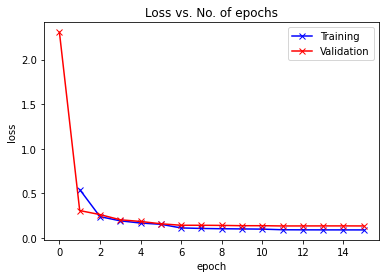

In [23]:
plot_losses(history)


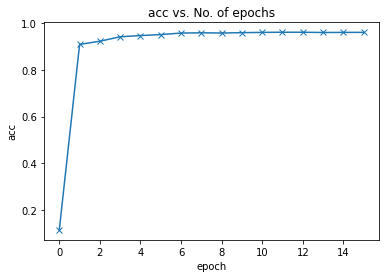

In [24]:
plot_scores(history)


In [25]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in dl:
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [x.argmax(dim=0) for x in batch_probs]

In [26]:
test_loader = DeviceDataLoader(test_loader, device)
test_preds = predict_dl(test_loader, model)

### Visualize test results

The test images are displayed in predicted(ground-truth). The text will be green for accurately classified examples and red for incorrect

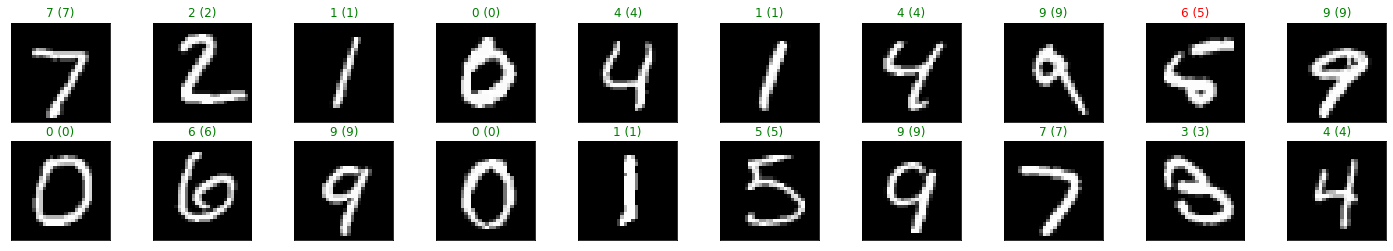

In [27]:
for images,labels in test_loader:
   break

#get sample outputs
output = model(images)

#convert output probabilities to predicted class
_,preds = torch.max(output,dim=1)

fig = plt.figure(figsize=(25,4))
for idx in range(20):
  ax = fig.add_subplot(2,20/2, idx+1, xticks = [],yticks=[])
  ax.imshow(images[idx].cpu().squeeze(),cmap='gray')
  ax.set_title("{} ({})".format(str(preds[idx].item()),labels[idx].item()),
                                color=("green" if preds[idx]==labels[idx] else "red"))

### Conclusion

We achieved a accuracy of 94% - Not bad!! 